## 136 - ANOVA

The statistical procedure that tests for a statistically significant difference among the groups is called analysis of variance, or ANOVA.


In [5]:
from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [17]:
four_sessions = pd.read_csv('four_sessions.csv')

    # The file shows the stickiness of four web pages, defined as the number of seconds a visitor spent on the page
    # There are a total of five visitors for each page, and each column is an independent set of data.
four_sessions

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172
5,Page 2,191
6,Page 3,193
7,Page 4,166
8,Page 1,177
9,Page 2,182


The more "pairwise" comparisons we make, the greater the potential for being fooled by random chance.

We can do a single overall test that addresses the question, “Could all the pages have the same underlying stickiness, and the differences among them be due to the ran‐ dom way in which a common set of session times got allocated among the four pages?”

The procedure used to test this is ANOVA. The basis for it can be seen in the following resampling procedure 
(specified here for the A/B/C/D test of web page stickiness):
1. Combine all the data together in a single box.
2. Shuffle and draw out four resamples of five values each.
3. Record the mean of each of the four groups.
4. Record the variance among the four group means.
5. Repeat steps 2–4 many (say, 1,000) times.

What proportion of the time did the resampled variance exceed the observed var‐ iance? This is the p-value.

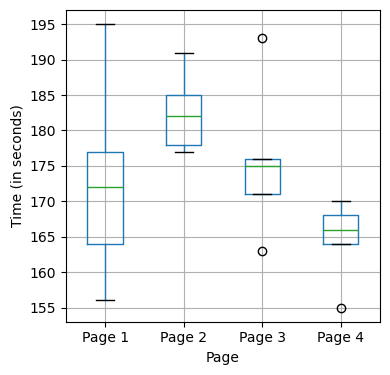

In [22]:
ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()


In [60]:
    # This line calculates the variance between different page means:

    # four_sessions.groupby('Page') groups the data by different pages
    # .mean() calculates the mean 'Time' for each page
    # .var() then calculates how much these means vary from each other:
    # (aka the variance: calculate the mean of those means, then for each value subtracts that mean, 
    # squares result and takes the avg of all squared differences)
    # .iloc[0] selects the first (and only) variance value

observed_variance = four_sessions.groupby('Page').mean().var().iloc[0]

    # Print the actual means for each page and the variance we calculated:
    # .values converts a pandas DataFrame or Series into a numpy array
    # .ravel() takes that array and flattens it into a 1-dimensional array

print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())

print('Variance:', observed_variance)


Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655


The "perm_test" function implements a key part of permutation testing. The idea is to simulate what the variance between page means would look like if there were no real relationship between pages and times. It does this by:

1) Making a copy of the dataframe to avoid modifying the original data
2) Randomly shuffling all the 'Time' values while keeping the 'Page' labels in place
3) Recalculating the variance between page means with this shuffled data

This is a powerful way to test whether the differences we observe between pages are meaningful or could have occurred by chance. If we run this permutation test many times and rarely see variances as large as our observed variance, it suggests the page differences are significant.
Think of it like shuffling a deck of cards: if you shuffle the times randomly across pages many times, how often would you see differences as large as what you actually observed? If it's rare, that suggests the original differences are meaningful rather than random chance.


The key point is that all the same Time values are still there, just randomly reassigned to different Pages. This is crucial for permutation testing because:

We keep all the same Time values (preserving the overall distribution)
But we break any potential relationship between Pages and Times by randomly shuffling
This helps us test if the original Page-Time relationship was meaningful or could have occurred by chance

In [115]:
# We define a function fot the permutation:

def perm_test(df):
    df = df.copy()

    # df['Time'] selects the Time column from your dataframe
    # .values converts it to a numpy array
    # np.random.permutation() randomly shuffles all these values
    
    df['Time'] = np.random.permutation(df['Time'].values)

    # Recalculates the variance between page means with this shuffled data and returns
    
    return df.groupby('Page').mean().var().iloc[0]
print(perm_test(four_sessions))


9.080000000000014


p-value 0.08033333333333334


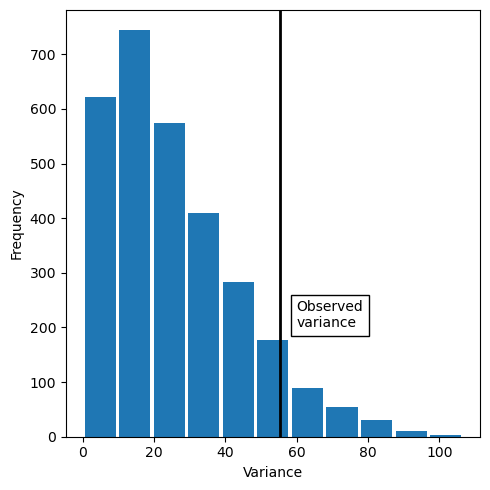

In [159]:
# Now we perform the function 3000 times:

    # Sets a random seed for reproducibility
random.seed(1) 

    
    # This creates a list of 3000 permuted variances. For each iteration:
    # It runs perm_test() which randomly shuffles the Time values
    # Calculates the variance between page means for that shuffle
    # Stores each variance in the list

perm_variance = [perm_test(four_sessions) for _ in range(3000)]

# Calculating the P-value (by checking how many of those 3000 values are above the one we found)

    # [var > observed_variance for var in perm_variance] creates a list of True/False values
    # Each True means that permuted variance was larger than what we actually observed
    # np.mean() gives us the proportion of permutations that exceeded our observed variance
    # This is our p-value - the probability of seeing such large differences between pages by chance

p_value = (np.mean([var > observed_variance for var in perm_variance]))

print('p-value', p_value)


# Visualization:

    # This creates a histogram showing:
    # Distribution of variances we got from random permutations
    # A vertical line showing where our actual observed variance falls
    # If the observed variance is far to the right of most permuted variances, it suggests the page differences are significant
    # This is a visual way to see how unusual our observed variance is compared to what we'd expect by chance.

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)  # Creates histogram of permuted variances
ax.axvline(x = observed_variance, color='black', lw=2) # Adds vertical line for observed variance
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'}) # Labels the line
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()



The p-value, given by Pr(Prob), is 0.09278(or similar). In other words, given the same underly‐ ing stickiness, 9.3% of the time the response rate among four pages might differ as much as was actually observed, just by chance. This degree of improbability falls short of the traditional statistical threshold of 5%, so we conclude that the difference among the four pages could have arisen by chance.

In [128]:
len(perm_variance)

3000

## Traditional ANOVA

Traditional ANOVA (Analysis of Variance) is the classical statistical method that uses F-tests to compare means between groups. Here's the key difference:

Permutation Test (what we just did):
- Randomly shuffles the data many times
- Calculates how often random shuffling produces differences as extreme as what we observed
- Makes no assumptions about the data's distribution
- The p-value is directly calculated from the proportion of permutations that exceed our observed value


Traditional ANOVA:
- Uses the F-statistic (ratio of between-group variance to within-group variance)
- Assumes the data follows a normal distribution
- Assumes equal variances between groups (homoscedasticity)
- P-value is calculated using the F-distribution

The permutation test we did is more flexible because it doesn't make assumptions about the data's distribution, but it requires more computational power since we need to run many permutations.

In [172]:
# The traditional ANOVA in Python would look something like this:

from scipy import stats

# Assuming four_sessions has 'Page' and 'Time' columns
groups = [group['Time'].values for name, group in four_sessions.groupby('Page')]
f_statistic, p_value = stats.f_oneway(*groups)

print("p-value:", p_value)
print("f-statistic:", f_statistic)

p-value: 0.0775862152580146
f-statistic: 2.739825341901467


## F-Statistic

We can compute an ANOVA table using statsmodel.

### F-Statistic ANOVA using statsmodels

In [174]:
# F-Statistic ANOVA using statsmodels:

    # smf.ols() creates an Ordinary Least Squares model where 'Time' is predicted by 'Page'
    # The formula 'Time ~ Page' means we're testing how 'Time' is affected by 'Page' 

model = smf.ols('Time ~ Page', data=four_sessions).fit()


    # anova_lm() performs a one-way ANOVA on this fitted model
aov_table = sm.stats.anova_lm(model)


    # This prints a full ANOVA table with sums of squares, degrees of freedom, F-statistic, etc.
print(aov_table)

# PR(>F) = p-value associated with the F-statistic for the hypothesis test.


# The ANOVA test performed by sm.stats.anova_lm(model) is inherently a two-sided test.
# Why?
# ANOVA tests whether any group mean is significantly different from the others, without assuming a specific direction 
# of difference (e.g., whether one group mean is greater or less than another).
# It considers deviations in both directions (higher or lower means), making it a two-tailed test.

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


### F-Statistic ANOVA using scipy.stats:


In [178]:
# F-Statistic ANOVA using scipy.stats:


    # stats.f_oneway() performs a one-way ANOVA using the F-test
    # Each argument is the 'Time' values for a specific page
    # Returns both the F-statistic and p-value

res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)

# The printing line was originally dividing by 2.. Not sure if that was an error as it makes it half of what other methods gave..
print(f'F-Statistic: {res.statistic:.4f}')
print(f'p-value: {res.pvalue:.4f}')

# No, you do not need to divide the p-value returned by scipy.stats.f_oneway by 2. 
# The p-value provided by f_oneway is already computed for a two-tailed test.

F-Statistic: 2.7398
p-value: 0.0776
